# Analyzing_Two_Photon_Data

On the previous page, we introduced how to retrieve specific experiments from the Allen Institute SDK's Brain Observatory. Here we'll introduce how researchers analyze this data, from processing single cell activity to understanding tuning curves.

### Setup
We need a variety of standard Python packages in addition to two different `allensdk` toolboxes. If you have not yet installed the `allensdk`, run the cell below. Otherwise, you can skip to the cell that imports our toolboxes.

In [4]:
# This will ensure that the AllenSDK is installed.
# If not, it will install it for you.
try:
    import allensdk
    print('allensdk already installed.')
except ImportError as e:
    !pip install allensdk

allensdk already installed.


In [5]:
# Import toolboxes
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

print('Packages installed.')

As a final setup step, we need to once again create an instance of the Brain Observatory Cache as an object, `boc`.

In [6]:
# Create an instance of the Brain Observatory cache
boc = BrainObservatoryCache(manifest_file='manifest.json')

## Download & inspect the natural scenes imaging session
First, we'll look at the session where the mouse viewed natural scenes. Below, we'll designate an experiment ID (the same one we worked with in the previous section), designate that we're interested in only the natural scenes experiments, and grab the container for that experiment.

*Note*: The cell below downloads some data, and make take a minute or so to run.

In [27]:
# Assign previous container id and stimulus for imaging 
exp_container_id = 637671552
stim = 'natural_scenes'

# Get experiment contianer for our id and stimuli of interest
expt_cont = boc.get_ophys_experiments(experiment_container_ids = [exp_container_id],
                                      stimuli = [stim])

session_id = expt_cont[0]['id']
data = boc.get_ophys_experiment_data(session_id)

print('Data acquired.')

Data acquired.


Let's take a quick look at the data you just acquired. We'll create a **maximum projection image** of the data, so that we can see the cells in our field of view. If we just looked at one snapshot of the raw imaging data, the cells would look dim -- they only become bright when they're actively firing. A maximum projection image shows us the maximum brightness for each pixel, across the entire experiment.

Below, we are using the `get_max_projection()` method on our data, and then using the `imshow()` method in order to see our projection.

*Note*: The weird text for the ylabel is called "TeX" markup, in order to get the greek symbol *mu* ($\mu$). See documentation <a href="https://matplotlib.org/tutorials/text/mathtext.html">here</a>.

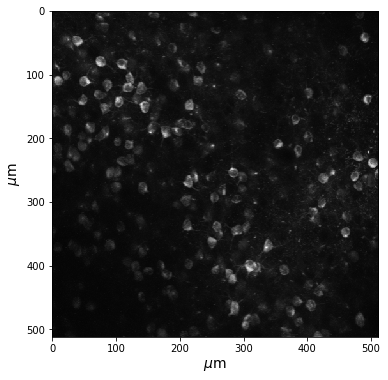

In [12]:
# Get the maximum projection (a numpy array) of our data
max_projection = data.get_max_projection()

# Create a new figure
fig = plt.figure(figsize=(6,6))

# Use imshow to visualize our numpy array
plt.imshow(max_projection, cmap='gray')

# Add labels for microns; weird syntax below is to get the micro sign
plt.ylabel(r'$\mu$m',fontsize=14)
plt.xlabel(r'$\mu$m',fontsize=14)
plt.show()

## Converting Calcium Imaging into Spikes 

Now we'll plot the data of each of our cells (from the field of view above) across time. Each line shows the change in fluorescence over baseline ($\Delta$)F/F) of the individual cells. When there are sharp increases, that's when the cells are responding.

In the example below, the we will plot the first 10 cells from our data. the `get_dff_traces()` method returns the timestamps (in seconds) and deltaF/F.

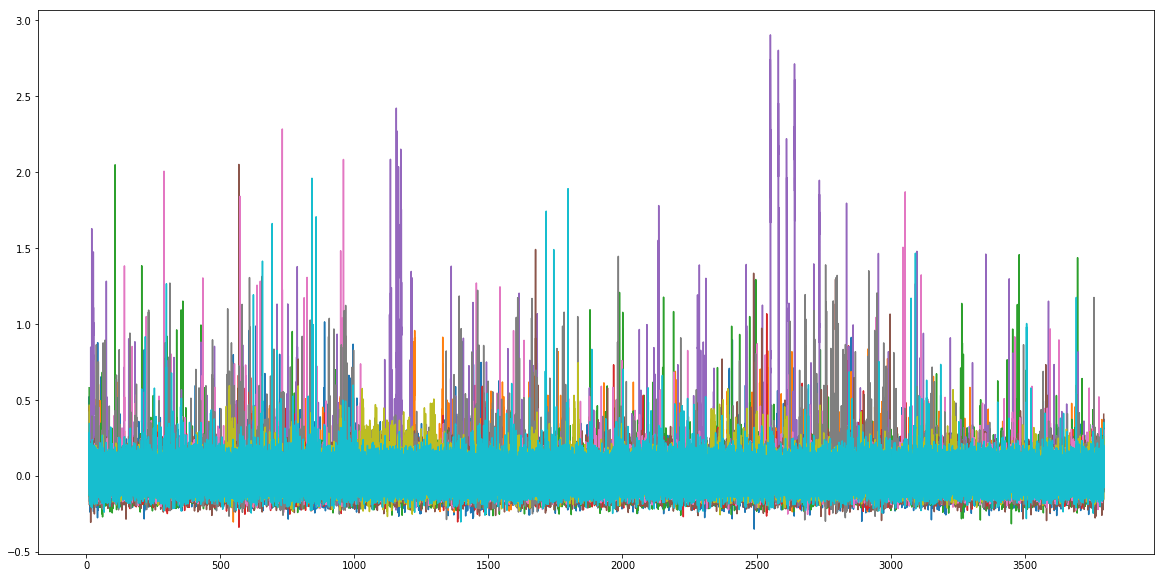

In [13]:
# Assign timestamps and deltaF/F
ts, dff = data.get_dff_traces()

# Set up a figure
fig = plt.figure(figsize=(20,10))

# Plot deltaF/F spikes over time for first 10 cells
for cell in range(10):
    plt.plot(ts, dff[cell])
    
plt.show()

Although the plotting of our fluorescence was successful, it's hard to see individual traces here. To solve this issue, we can add a line in our loop that offsets each cell by a predetermined amount. We'll also zoom in on the x-axis so we can see what individual calcium responses look like.

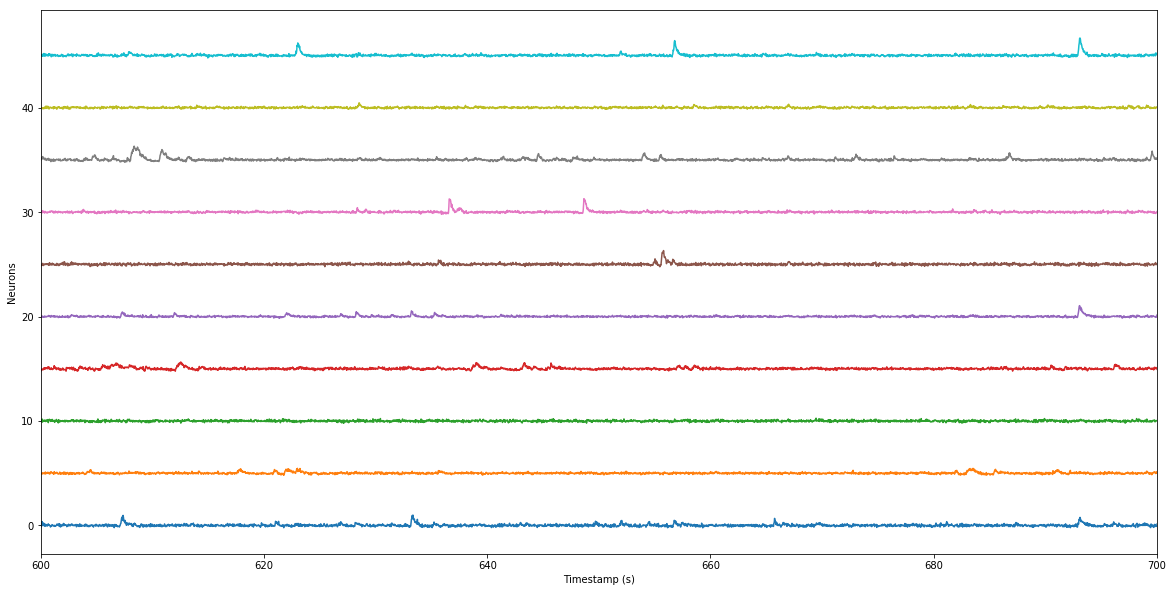

In [25]:
## MAKE THIS SCROLLABLE :)

fig = plt.figure(figsize=(20,10))

offset = 0

for cell in range(10):
    plt.plot(ts, dff[cell]+offset)
    offset+=5
plt.xlabel('Timestamp (s)')
plt.ylabel('Neurons')
plt.xlim([600,700])
plt.show()

## Look at the response of your cells to natural scenes
Hmm, there are some responses above, but it's tough to see what's going on with just the raw traces. Let's instead see how these cells actually responded to different types of images. To do so, we'll need to use the `get_cell_specimens()` method on our `boc`, giving it the name of the experiment container ID.

The dataframe that this creates will have a lot more information about what the cells in our experiment prefer. Each row is a different cell, each with its own preferences and response patterns.

In [28]:
# Get the cell specimens information for this session
cell_specimens = boc.get_cell_specimens(experiment_container_ids=[exp_container_id])
cell_specimens_df = pd.DataFrame(cell_specimens)
cell_specimens_df.head()

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
0,False,VISp,661977791,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,NaN,637671552,False,NaN,NaN,NaN,...,606727216,NaN,NaN,NaN,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
1,False,VISp,661977825,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,NaN,637671552,False,NaN,NaN,0.702021,...,606727216,NaN,0.23219,0.29853,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
2,False,VISp,661977840,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,NaN,637671552,False,NaN,NaN,0.929398,...,606727216,NaN,0.23219,0.33170,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
3,False,VISp,661977854,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,NaN,637671552,False,NaN,NaN,NaN,...,606727216,NaN,NaN,NaN,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
4,True,VISp,661977873,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,1.096741,637671552,False,0.547736,0.195726,0.717951,...,606727216,0.235342,0.29853,0.29853,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)


Let's create a bar graph of preferred images in our dataset. The `p_ns` column contains the pvalue that corresponds to whether a cell *significantly* prefered an image more than the rest. We will subselect our `cell_specimens_df` dataframe to only contains cells that have a pvalue less than 0.05. 

The `pref_image_ns` column contians the image IDs of the stimulus being presented. We can create our histogram from this column to see how many cells responded to these statistically significant stimuli. 

In [42]:
hi = pref_images.value_counts()
hi.index[0]

90.0

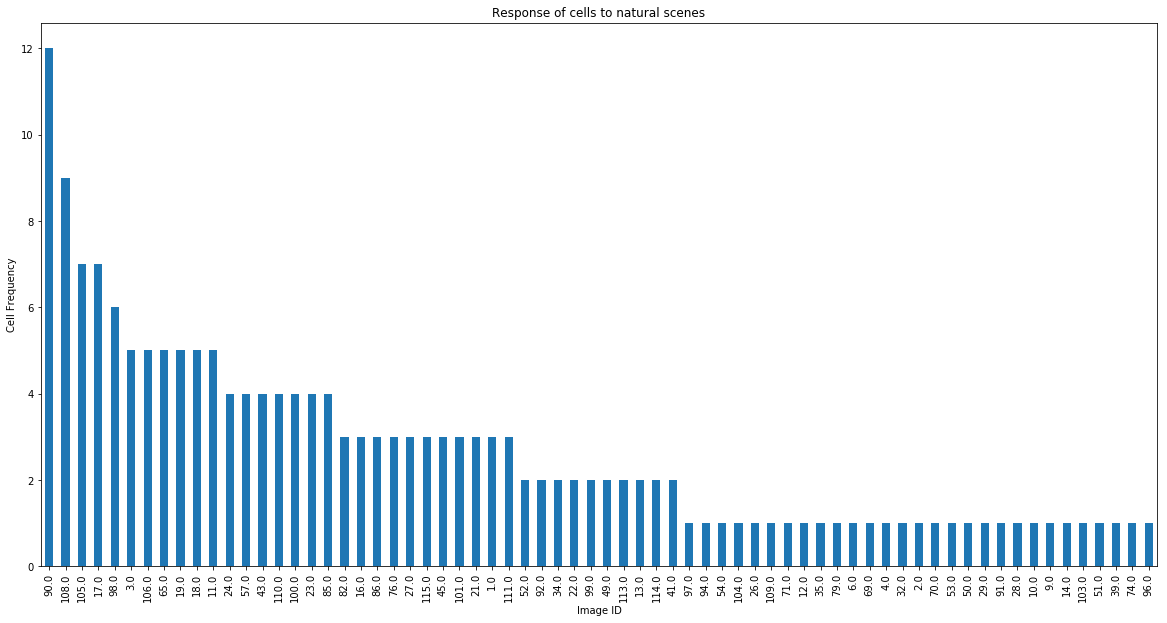

In [40]:
# Subselect dataframe to contain significantly preferred images 
sig_cells = cell_specimens_df[cell_specimens_df['p_ns'] < 0.05]

# Assign our image ids
pref_images = sig_cells['pref_image_ns']

# Set up our figure 
fig = plt.figure(figsize = [20,10])

# Plot our bar graph
pref_counts = pref_images.value_counts()
pref_counts.plot(kind='bar')
plt.title('Response of cells to natural scenes')
plt.ylabel('Cell Frequency')
plt.xlabel('Image ID')
plt.show()

In order to actually see what this stimulus are, first, we'll organize the stimulus table. This tells us which stimulus was played on each trial. This data set has 118 different scenes, and each scene is presented 50 times. Images of the scenes can be found [here](http://observatory.brain-map.org/visualcoding/stimulus/natural_scenes).

Below, we'll show the top five images for cells in this field of view. Do they have anything in common, either visually or conceptually?

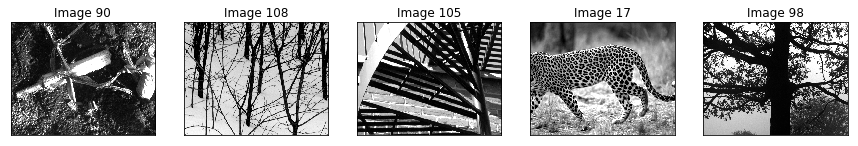

In [49]:
# Get the natural scene information
natural_scene_template = data.get_stimulus_template('natural_scenes')

# Set up our figure
fig,ax = plt.subplots(1,5,figsize=(15,6))

for image_ID in range(5): # Show the first 5 images
    
    image_id = int(pref_counts.index[image_ID]) # Get the image ID

    # Use imshow to visualize our numpy array
    ax[image_ID].imshow(natural_scene_template[image_id,:,:],cmap='gray')
    ax[image_ID].set_xticks([])
    ax[image_ID].set_yticks([])
    ax[image_ID].set_title('Image ' + str(image_id))
    
plt.show()

## Examine the direction selectivity of your cell
Sometimes, the function of a cell is not particularly clear from natural stimuli. Those stimuli have a lot of information in them, and it might be hard to tell what a cell is actually responding to. Instead, we can use simple drifting gratings to look at one straightforward property of a cell: <b>does it respond to specific directions of movement?</b></br>

We can use the columns that look at the direction selectivity index (DSI) in order to determine whether our cells are direction selective (typically considered having a DSI > 0.5). Take another look at the cell_specimens_df we created above. We can subselect `sig_cells` to only contain cells that were direction specific and replot our bar graph to compare. 

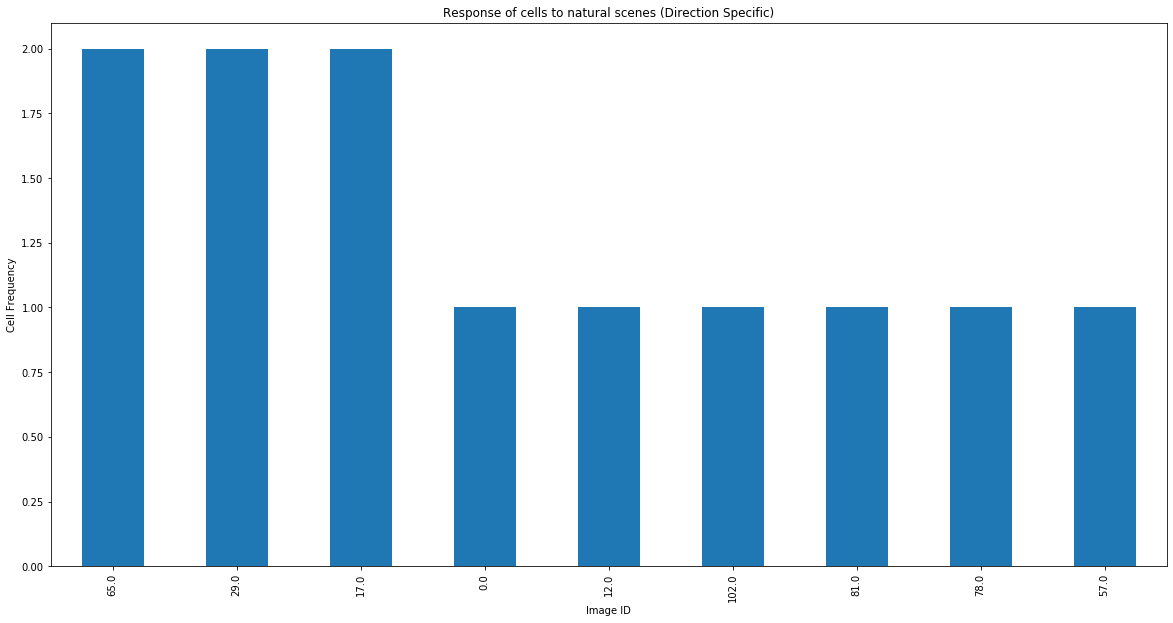

In [23]:
dsi_cells = sig_cells[sig_cells['dsi_dg'] > 0.5]

pref_images_dsi = dsi_cells['pref_image_ns']

# Set up our figure 
fig = plt.figure(figsize = [20,10])

# Plot our bar graph
pref_images_dsi.value_counts().plot(kind='bar')
plt.title('Response of cells to natural scenes (Direction Specific)')
plt.ylabel('Cell Frequency')
plt.xlabel('Image ID')
plt.show()

As you can see our plot has drastically changed. Our cells were only direction selective to nine images from the significantly preferred data.